# Model baseline

## Descarga del dataset

In [1]:
!wget https://storage.googleapis.com/diabetic-detection/data_downscaled.zip

--2020-11-07 04:25:29--  https://storage.googleapis.com/diabetic-detection/data_downscaled.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 173.194.217.128, 108.177.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 990385145 (945M) [application/zip]
Saving to: ‘data_downscaled.zip’

data_downscaled.zip 100%[===================>] 944.50M   211MB/s    in 4.7s    

2020-11-07 04:25:34 (202 MB/s) - ‘data_downscaled.zip’ saved [990385145/990385145]



In [14]:
!unzip -o -q data_downscaled
!mv .tmp dataset
!mv dataset/raw_dataset_extracted_downscaled data
!rm -rf dataset

In [15]:
!ls -l data

total 4184
drwxr-xr-x 2 root root    4096 Nov  7 04:30 sample
-rw-r--r-- 1 root root  709972 Nov  6 05:56 sampleSubmission.csv
drwxr-xr-x 2 root root 1908736 Nov  7 04:30 test
drwxr-xr-x 2 root root 1191936 Nov  7 04:30 train
-rw-r--r-- 1 root root  465317 Nov  6 05:56 trainLabels.csv


## Carga del dataset

In [82]:
import pandas as pd
import numpy as np
import os, sys, shutil

Creo el dataframe en orden lexicografico respecto los nombres de los archivos.

In [23]:
labels = pd.read_csv('data/trainLabels.csv') \
  .sort_values(by = 'image')

In [26]:
labels.head(2)

,image,level
7982,10003_left,0
7983,10003_right,0


In [45]:
labels.level.value_counts() / labels.level.shape[0], labels.level.value_counts()

(0    0.734783
 2    0.150658
 1    0.069550
 3    0.024853
 4    0.020156
 Name: level, dtype: float64, 0    25810
 2     5292
 1     2443
 3      873
 4      708
 Name: level, dtype: int64)

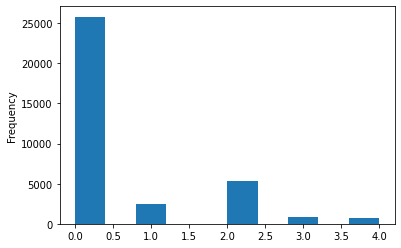

In [69]:
labels.level.plot(kind = 'hist')

## Resampling

Trabajo con maximo 1000 imagenes de cada clase para que esten mas balanceadas.

In [74]:
resampled = labels.groupby('level', as_index = False,group_keys=False) \
  .apply(lambda column: column.sample(min(len(column), 1000)))

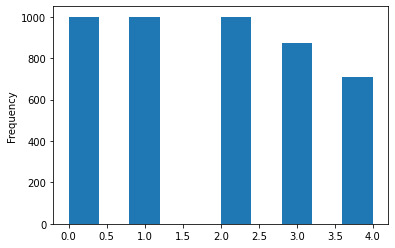

In [75]:
resampled.level.plot(kind = 'hist')

In [109]:
resampled = resampled.sort_values(by = 'image')

In [80]:
resampled.level.value_counts() / resampled.level.shape[0]

2    0.218293
1    0.218293
0    0.218293
3    0.190570
4    0.154551
Name: level, dtype: float64

In [108]:
resampled.shape[0]

4581

Creo una nueva carpeta de train mejor balanceada

In [211]:
orig_dir = 'data/train'
dest_dir = 'data/train_balanced'

if not os.path.exists(dest_dir):
  os.mkdir(dest_dir)

for _, item in resampled.image.items():
  ext = '.jpeg'
  orig_file = os.path.join(orig_dir, item + ext)
  dest_file = os.path.join(dest_dir, item + ext)
  shutil.copy(orig_file, dest_file)

Separo dos partes para test y validacion

In [212]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(resampled, train_size = 0.8)

In [213]:
train.shape[0], test.shape[0]

(3664, 917)

In [214]:
label_names = {
  0: 'No DR',
  1: 'Mild',
  2: 'Moderate',
  3: 'Severe',
  4: 'Proliferative DR'
}

In [215]:
def create_directory_flow(df, subset_name):
  for _, row in df.iterrows():
    item = row.image
    level = row['level']
    label_name = label_names[level]
    basedir = 'data/train_balanced'
    ext = '.jpeg'
    orig_file = os.path.join(orig_dir, item + ext)
    os.makedirs(os.path.join(dest_dir, subset_name, label_name), exist_ok=True)
    dest_file = os.path.join(dest_dir, subset_name, label_name, item + ext)
    shutil.copy(orig_file, dest_file)

In [216]:
create_directory_flow(train, 'train')
create_directory_flow(test, 'validation')

In [217]:
! rm -rf data/train_balanced/*.jpeg
! mv data/train_balanced data/balanced

mv: cannot move 'data/train_balanced' to 'data/balanced/train_balanced': Directory not empty


Aprovecho para zipear y descargar este proceso, asi lo puedo utilizar en notebooks mas adelante.

In [218]:
train.to_csv('data/balanced/train_labels.csv')
test.to_csv('data/balanced/validation_labels.csv')

In [219]:
! cd data && zip -q -r 'flow_balanced_data.zip' 'balanced'

## Modelo baseline sin data augmentation

Para comenzar solamente aplicamos el reescalado, usando los canales de colores originales del dataset.

In [220]:
from keras.preprocessing.image import ImageDataGenerator

train_path = os.path.join('data', 'balanced', 'train')
validation_path = os.path.join('data', 'balanced', 'validation')

# Reescalamos todas las imágenes en un factor de 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# La función flow_from_directory() toma el path a un directorio
# y genera batches de data a la que aplica las transformaciones definidas
train_generator = train_datagen.flow_from_directory(
        # Directorio target
        train_path,
        # Reescalamos las imágenes a tamaño 150x150
        target_size=(224, 224),
        batch_size=32,
        # Usamos etiquetas binarias, ya que usamos binary_crossentropy
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=32,
        shuffle=False,
        class_mode='categorical')

Found 3664 images belonging to 5 classes.
Found 3664 images belonging to 5 classes.


In [221]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 24, 24, 128)      

In [222]:
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-4),
    metrics=['accuracy']
)

In [223]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
  )

Epoch 1/30
115/115 [==============================] - 464s 4s/step - loss: 0.5121 - accuracy: 0.7951 - val_loss: 0.5016 - val_accuracy: 0.8000
Epoch 2/30
115/115 [==============================] - 462s 4s/step - loss: 0.5033 - accuracy: 0.8000 - val_loss: 0.5017 - val_accuracy: 0.8000
Epoch 3/30
115/115 [==============================] - 470s 4s/step - loss: 0.5018 - accuracy: 0.8000 - val_loss: 0.5015 - val_accuracy: 0.8000
Epoch 4/30
115/115 [==============================] - 465s 4s/step - loss: 0.5013 - accuracy: 0.8000 - val_loss: 0.5009 - val_accuracy: 0.8000
Epoch 5/30
115/115 [==============================] - 461s 4s/step - loss: 0.5010 - accuracy: 0.8000 - val_loss: 0.5010 - val_accuracy: 0.8000
Epoch 6/30
115/115 [==============================] - 462s 4s/step - loss: 0.5009 - accuracy: 0.8000 - val_loss: 0.5009 - val_accuracy: 0.8000
Epoch 7/30
115/115 [==============================] - 463s 4s/step - loss: 0.5008 - accuracy: 0.8000 - val_loss: 0.5007 - val_accuracy: 0.8000